In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.utils import class_weight


In [2]:
train = pd.read_csv("TrainOnMe-2.csv")
test = pd.read_csv("EvaluateOnMe-2.csv")

In [3]:
test.head()

,Unnamed: 0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
0,1000,0.81313,0.38023,5.85070,-9.18530,9.93106,0.36759,Jerry Fernström,1.83292,1.89491,-6.29609,-0.62245,True,43.58182
1,1001,0.05435,0.89732,1.50829,-8.79618,9.84085,0.83846,Erik Sven Fernström,-1.75396,-0.71970,-8.54241,-2.00896,True,3.47168
2,1002,0.93130,1.13181,-6.25123,-9.24025,9.97088,1.10935,Erik Sven Fernström,-1.89190,-0.71282,-11.91278,-0.24137,False,43.43945
3,1003,0.81462,0.32761,-2.58948,-9.90454,10.21894,0.28165,Jerry Fernström,0.71816,0.55542,-9.96034,-1.35239,False,39.43638
4,1004,2.02671,0.71385,-4.34367,-9.14374,10.12963,0.72507,Jerry Fernström,0.43896,1.29437,-7.76422,-1.28642,False,99.16370


In [4]:
train.head()

,Unnamed: 0,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
0,0,Shoogee,2.20274,-0.04690,-4.69816,-9.07800,10.13118,-0.08900,Erik Sven Williams,0.54191,0.52041,-5.66990,-0.93831,False,107.78776
1,1,Bob,2.01516,-0.12177,-4.24286,-9.79772,9.98259,-0.01485,Erik Sven Williams,-1.21671,1.18749,-9.25300,-1.21892,False,98.63633
2,2,Bob,0.02598,-0.24764,0.39977,-9.54167,10.53391,-0.27978,Erik Sven Williams,-2.39764,1.95167,-9.46447,-2.68910,True,1.49880
3,3,Jorg,0.39778,-0.83343,-2.14272,-9.06550,10.15047,-0.84583,Jerry från Solna,0.09768,0.92010,-11.17952,0.59877,False,18.81785
4,4,Jorg,1.25346,0.09320,1.54063,-9.33171,9.92016,0.09889,Jerry Fernström,-0.46134,0.16381,-12.07755,1.09106,True,63.44326


In [5]:
test = test.drop("Unnamed: 0", axis = 1)

In [6]:
for i, row in train["Unnamed: 0"].iteritems():
    try:
        row = int(row)
    except:
        print(i, row)

134 https://youtu.be/74TDvzZcHPw
581 Det är då som det stora vemodet rullar in
582 Och från havet blåser en isande
803 Den här är felt. Darfor erase it.


In [7]:
train = train.drop("Unnamed: 0", axis = 1)

In [8]:
train.dropna(inplace=True, axis=0)

In [9]:
from sklearn.utils import shuffle

train = shuffle(train, random_state = 0)

In [10]:
train = train.reset_index(drop = True)

In [11]:
for i, val in train["x6"].iteritems():
  try:
    float(val)
  except:
    print(i,val)
    print(train.iloc[i])
    train.drop(i, inplace = True)

137 https://youtu.be/0q_Bbd2SGtY
y                              Jorg
x1                          0.88362
x2                          0.12864
x3                         -4.91248
x4                         -9.41917
x5                          10.0493
x6     https://youtu.be/0q_Bbd2SGtY
x7                  Jerry Fernström
x8                          0.60795
x9                           2.3159
x10                        -5.25392
x11                        -1.40652
x12                           False
x13                         41.7249
Name: 137, dtype: object


In [12]:
train = train.astype({"x6": float})
train = train.astype({"x12": bool})

In [13]:
train = train.reset_index()

In [14]:
encoder = dict()
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

for column in train.columns:
    if train[column].dtype == "object":
        print(column)
        train[column + "enc"] = labelencoder.fit_transform(train[column])
        encoder[column] = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))

y
x7


In [15]:
test.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
0,0.81313,0.38023,5.85070,-9.18530,9.93106,0.36759,Jerry Fernström,1.83292,1.89491,-6.29609,-0.62245,True,43.58182
1,0.05435,0.89732,1.50829,-8.79618,9.84085,0.83846,Erik Sven Fernström,-1.75396,-0.71970,-8.54241,-2.00896,True,3.47168
2,0.93130,1.13181,-6.25123,-9.24025,9.97088,1.10935,Erik Sven Fernström,-1.89190,-0.71282,-11.91278,-0.24137,False,43.43945
3,0.81462,0.32761,-2.58948,-9.90454,10.21894,0.28165,Jerry Fernström,0.71816,0.55542,-9.96034,-1.35239,False,39.43638
4,2.02671,0.71385,-4.34367,-9.14374,10.12963,0.72507,Jerry Fernström,0.43896,1.29437,-7.76422,-1.28642,False,99.16370


In [16]:
encoder_test = dict()
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

for column in test.columns:
    if test[column].dtype == "object":
        test[column + "enc"] = labelencoder.fit_transform(test[column])
        encoder_test[column] = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))

In [17]:
testM = test[["x1","x2","x3","x4","x5","x6", "x8","x9","x10","x11","x13","x7enc", "x12"]]

In [18]:
trainM = train[["x1","x2","x3","x4","x5","x6", "x8","x9","x10","x11","x13","yenc","x7enc","x12"]]

In [19]:
testM.head()

,x1,x2,x3,x4,x5,x6,x8,x9,x10,x11,x13,x7enc,x12
0,0.81313,0.38023,5.85070,-9.18530,9.93106,0.36759,1.83292,1.89491,-6.29609,-0.62245,43.58182,2,True
1,0.05435,0.89732,1.50829,-8.79618,9.84085,0.83846,-1.75396,-0.71970,-8.54241,-2.00896,3.47168,0,True
2,0.93130,1.13181,-6.25123,-9.24025,9.97088,1.10935,-1.89190,-0.71282,-11.91278,-0.24137,43.43945,0,False
3,0.81462,0.32761,-2.58948,-9.90454,10.21894,0.28165,0.71816,0.55542,-9.96034,-1.35239,39.43638,2,False
4,2.02671,0.71385,-4.34367,-9.14374,10.12963,0.72507,0.43896,1.29437,-7.76422,-1.28642,99.16370,2,False


In [20]:
trainM.head()

,x1,x2,x3,x4,x5,x6,x8,x9,x10,x11,x13,yenc,x7enc,x12
0,1.23351,-0.16595,0.14108,-8.58171,10.48806,-0.24662,-1.13877,1.33294,-7.24812,-1.72873,61.74613,3,1,False
1,-0.06859,-0.03913,-5.67505,-9.02809,10.02502,-0.03694,-0.24194,-0.04031,-5.26454,1.61433,-6.26681,2,1,False
2,1.01218,0.32650,-6.55152,-9.33834,10.14469,0.43469,1.10164,-0.01411,-9.33047,-2.59679,47.33314,0,2,False
3,0.57296,-0.40369,-1.73764,-9.01203,9.86515,-0.39589,1.32041,0.94174,-6.46244,0.50173,27.77929,2,1,False
4,-0.08716,0.14848,-3.37625,-9.05578,10.53105,0.09952,-1.61032,-1.31704,-11.09431,-2.09815,-6.04600,1,2,False


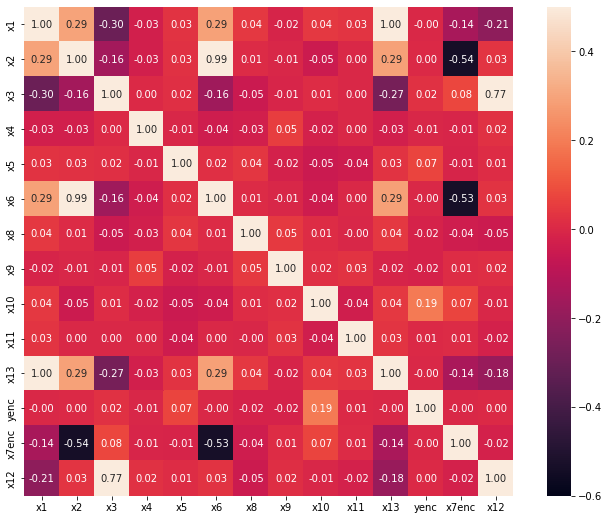

In [21]:
corrmat = trainM.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmin = -0.6 ,vmax=0.5, annot=True, square=True, fmt='.2f');

# Model

In [44]:
class Classifyer:
    def __init__(self, data, test_split, fidx, lidx):

    trainY, trainX = data["yenc"], data.drop("yenc", axis=1)

    self.train_X = trainX.drop([i for i in range(fidx, lidx)]).to_numpy()
    self.test_X = trainX.iloc[fidx:lidx].to_numpy()
    self.train_y = trainY.drop([i for i in range(fidx, lidx)]).to_numpy()
    self.test_y = trainY.iloc[fidx:lidx].to_numpy()

    self.trainY = trainY
    self.trainX = trainX

    print(fidx, lidx)
    print("Train",np.unique(self.train_y,return_counts=True))
    print("Test",np.unique(self.test_y,return_counts=True))
    

    self.space={
        'gamma': hp.uniform ('gamma', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'max_depth': hp.uniform("max_depth", 3, 10),
        "learning_rate": hp.uniform("learning_rate", 0.01,1),
        'min_child_weight' : hp.uniform('min_child_weight', 2, 5),
        "subsample": hp.uniform("subsample", 0,1),
        'n_estimators': 200,
        'seed': 0,
        'reg_alpha' : hp.uniform('reg_alpha', 0,10),
        }

    self.hyperparams = None
    self.accuracy = None

    trials = Trials()
    best_hyperparams = fmin(fn = self.learning,
                        space = self.space,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

    best_hyperparams["seed"], best_hyperparams["n_estimators"] = 0, 200

    tmp = self.learning(best_hyperparams)
    self.model = tmp["model"]
    self.accuracy = -tmp["loss"]
    self.hyperparams = best_hyperparams

  def returner(self):
    return self.model, self.accuracy, self.hyperparams
    
  def learning(self,space):
    """xgb_m = XGBClassifier(n_estimators = space['n_estimators'], 
                        learning_rate = space["learning_rate"],
                        max_depth = int(space['max_depth']), 
                        gamma = space['gamma'],
                        reg_alpha = space['reg_alpha'],
                        min_child_weight= space['min_child_weight'],
                        seed = space["seed"])"""

    xgb_m = XGBClassifier(n_estimators = space['n_estimators'], 
                        learning_rate = space["learning_rate"],
                        max_depth = int(space['max_depth']), 
                        min_child_weight= space['min_child_weight'],
                        seed = space["seed"],
                        gamma = space['gamma'],
                        reg_alpha = space['reg_alpha'],
                        colsample_bytree = space['colsample_bytree'],
                        subsample = space["subsample"])
    
    classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=self.train_y)
    
    xgb_m.fit(self.train_X, self.train_y, 
              sample_weight = classes_weights)

    accuracies = cross_val_score(estimator = xgb_m, X = self.trainX, y = self.trainY, cv = 10)
    accuracy = accuracies.mean()
    #pred = xgb_m.predict(self.test_X)
    #accuracy = accuracy_score(self.test_y, pred)
    return {'loss': -accuracy, 'status': STATUS_OK , "model": xgb_m}    

    
    


In [45]:
N = 5
tests = np.array_split(trainM, N)
models = list()
accs = list()
hypers = list()
for i in range(N):
  print("Iter", i)
  for j in range(1):
    c = Classifyer(trainM, 0.1, tests[i].first_valid_index(),tests[i].last_valid_index())
    model, acc, hyper = c.returner()
    accs.append(acc)
    hypers.append(hyper)
    models.append(model)

Iter 0
0 198
Train (array([0, 1, 2, 3]), array([ 73, 219, 272, 233]))
Test (array([0, 1, 2, 3]), array([22, 49, 70, 57]))
100%|██████████| 50/50 [07:08<00:00,  8.57s/it, best loss: -0.6210404040404041]
Iter 1
199 397
Train (array([0, 1, 2, 3]), array([ 77, 203, 289, 228]))
Test (array([0, 1, 2, 3]), array([18, 65, 53, 62]))
100%|██████████| 50/50 [05:41<00:00,  6.83s/it, best loss: -0.6170707070707071]
Iter 2
398 596
Train (array([0, 1, 2, 3]), array([ 74, 221, 265, 237]))
Test (array([0, 1, 2, 3]), array([21, 47, 77, 53]))
100%|██████████| 50/50 [05:54<00:00,  7.10s/it, best loss: -0.626090909090909]
Iter 3
597 795
Train (array([0, 1, 2, 3]), array([ 77, 212, 274, 234]))
Test (array([0, 1, 2, 3]), array([18, 56, 68, 56]))
100%|██████████| 50/50 [05:53<00:00,  7.07s/it, best loss: -0.6190808080808081]
Iter 4
796 994
Train (array([0, 1, 2, 3]), array([ 79, 218, 270, 230]))
Test (array([0, 1, 2, 3]), array([16, 50, 72, 60]))
100%|██████████| 50/50 [06:13<00:00,  7.46s/it, best loss: -0.6

In [46]:
trainY, trainX = trainM["yenc"], trainM.drop("yenc", axis=1)
T = 2
for i in range(N):
  
  space = hypers[i]
  model = XGBClassifier(n_estimators = space['n_estimators'], 
                        learning_rate = space["learning_rate"],
                        min_child_weight= space['min_child_weight'],
                        seed = space["seed"],
                        gamma = space['gamma'],
                        colsample_bytree = space['colsample_bytree'])
  
  model = models[i]
  pred = model.predict(trainX.to_numpy())
  accuracy = accuracy_score(trainY.to_numpy(), pred)
  print("ACC:", accuracy)
  """score = cross_val_score(model, trainX.to_numpy(), trainY.to_numpy(), cv = T, scoring = "accuracy")
  print("\n")
  print(score)
  print("Accuracy:",score.mean())
  print("Std",score.std())"""

ACC: 0.8984924623115578
ACC: 0.8994974874371859
ACC: 0.7728643216080402
ACC: 0.914572864321608
ACC: 0.7608040201005025


In [60]:
tests = np.array_split(trainM, N)
for i in range(N):
  avg = list()
  for j in range(N):
    fidx , lidx = tests[j].first_valid_index(),tests[j].last_valid_index()
    pred = models[i].predict(trainX.iloc[fidx:lidx].to_numpy())
    accuracy = accuracy_score(trainY.iloc[fidx:lidx].to_numpy(), pred)
    avg.append(accuracy)
    #print("Model", i,"X", j)
    #print("I:",fidx,lidx," Acc:",accuracy)
  print("Model", i)
  print("Min:", min(avg))
  print("Mean", sum(avg)/5)

Model 0
Min: 0.6060606060606061
Mean 0.8979797979797979
Model 1
Min: 0.6414141414141414
Mean 0.898989898989899
Model 2
Min: 0.5353535353535354
Mean 0.7717171717171717
Model 3
Min: 0.6464646464646465
Mean 0.9141414141414141
Model 4
Min: 0.6060606060606061
Mean 0.7616161616161616


In [55]:
import pickle
pickle.dump(models[3], open("pima.pickle.dat", "wb"))
loaded_model = pickle.load(open("pima.pickle.dat", "rb"))

In [56]:
loaded_model = pickle.load(open("pima.pickle.dat", "rb"))

In [57]:
print(models[3])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9210754002686283,
              gamma=0.45408850458904904, learning_rate=0.4622584476408178,
              max_delta_step=0, max_depth=4, min_child_weight=4.860250726784588,
              missing=None, n_estimators=200, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=0,
              reg_alpha=1.366462371014041, reg_lambda=1, scale_pos_weight=1,
              seed=0, silent=None, subsample=0.9287356570221919, verbosity=1)


In [61]:
test_pred = models[3].predict(testM.to_numpy())

In [69]:
_, disttest = np.unique(test_pred, return_counts = True)

In [70]:
_, disttrain = np.unique(trainY, return_counts = True)

In [73]:
disttest/len(test_pred)

array([0.1247, 0.2224, 0.3705, 0.2824])

In [74]:
disttrain/len(trainY)

array([0.09547739, 0.26934673, 0.34371859, 0.29145729])

In [76]:
encoder

{'x7': {'Erik Sven Fernström': 0,
  'Erik Sven Williams': 1,
  'Jerry Fernström': 2,
  'Jerry Williams': 3,
  'Jerry från Solna': 4},
 'y': {'Atsuto': 0, 'Bob': 1, 'Jorg': 2, 'Shoogee': 3}}

In [77]:
test_pred_new = list()
for i in range(len(test_pred)):
  if test_pred[i] == 0:
    test_pred_new.append('Atsuto')
  if test_pred[i] == 1:
    test_pred_new.append('Bob')
  if test_pred[i] == 2:
    test_pred_new.append('Jorg')
  if test_pred[i] == 3:
    test_pred_new.append('Shoogee')

In [81]:
np.unique(np.asarray(test_pred_new), return_counts=True)

(array(['Atsuto', 'Bob', 'Jorg', 'Shoogee'], dtype='<U7'),
 array([1247, 2224, 3705, 2824]))

In [82]:
np.unique(test_pred, return_counts=True)

(array([0, 1, 2, 3]), array([1247, 2224, 3705, 2824]))

In [90]:
np.savetxt("result.txt", test_pred_new, fmt = "%s")

In [94]:
truer = np.loadtxt("result.txt",dtype="str") == test_pred_new

In [96]:
np.unique(truer)

array([ True])